In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [62]:
df = pd.read_csv("clutch_events.csv")

#print(df.shape)
#print(df.head())


In [70]:
y = df["clutch_success"]

drop_cols = [
    "clutch_success", 
    "clutch_kills",    
    "demo_file",       
    "map",            
    "player_name", 
    "steamid64"
]

drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (655, 20) Test size: (164, 20)


In [72]:
# Separate numerical & categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical:", num_features)
print("Categorical:", cat_features)

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


Numerical: ['round', 'start_tick', 'start_time_s', 'time_left_s', 'start_vs', 'teammates_alive', 'enemies_alive', 'player_hp', 'player_armor', 'has_helmet', 'has_kit', 'player_equip_value', 'enemy_equip_value', 'bomb_planted', 'time_since_plant_s', 'round_end_reason']
Categorical: ['side', 'plant_site', 'weapon', 'round_winner_side']


In [75]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"  
    ))
])

clf.fit(X_train, y_train)

print("Train acc:", clf.score(X_train, y_train))
print("Test acc:", clf.score(X_test, y_test))


Train acc: 1.0
Test acc: 0.9512195121951219


In [76]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       154
           1       1.00      0.20      0.33        10

    accuracy                           0.95       164
   macro avg       0.98      0.60      0.65       164
weighted avg       0.95      0.95      0.94       164



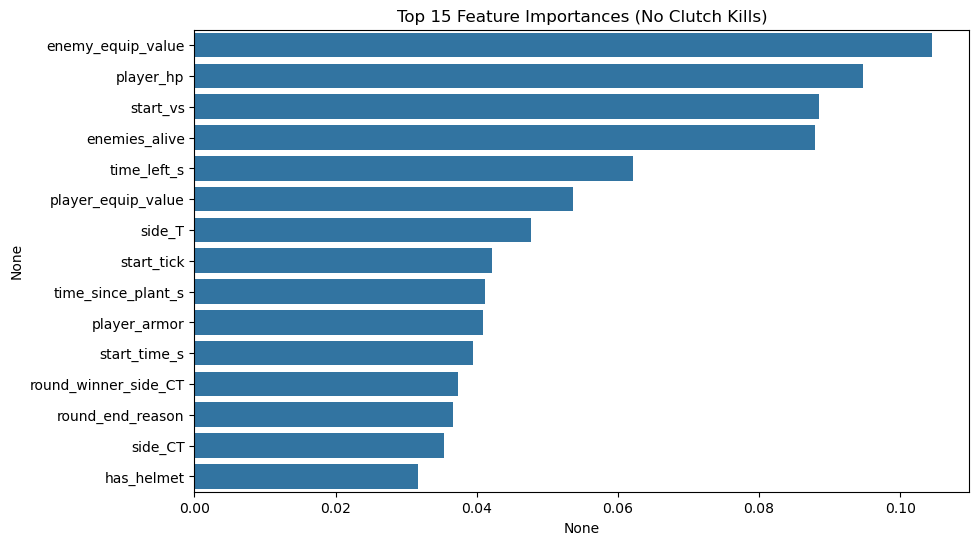

In [77]:
# feature names after preprocessing
feature_names = (
    num_features +
    list(clf.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features))
)

importances = clf.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# top 15
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index)
plt.title("Top 15 Feature Importances (No Clutch Kills)")
plt.show()


### 1. **Enemy Equipment Value** (most important)
- The total value of enemy gear (weapons, armor, utility) is the single strongest predictor.  
- Higher enemy equipment value makes a clutch **less likely**, since opponents are better armed.  

---

### 2. **Player HP**
- The second most important feature.  
- A player with higher HP has a significantly better chance of winning a clutch.  

---

### 3. **Start_vs (Starting Advantage)**
- Represents how many opponents the clutching player faces at the start.  
- Fewer enemies = higher clutch probability.  

---

### 4. **Enemies Alive**
- Closely related to *start_vs*.  
- The fewer enemies alive, the easier the clutch.  

---

### 5. **Time Left in Round**
- Having more time gives the clutching player flexibility to reposition, bait, and attempt defuses or plants.  
- Shorter time reduces chances drastically.  

---

### 6. **Player Equipment Value**
- The clutching player’s own equipment is important.  
- Better guns, armor, and utility increase the odds of winning.  

---

### 7. **Side (T or CT)**
- Whether the player is **Terrorist (T)** or **Counter-Terrorist (CT)** matters.  
- Certain clutch scenarios are easier depending on the side (e.g., Ts after bomb plant, CTs on retake).  

---

### 8–15. **Other Contributing Factors**
- **Start tick / Start time**: Proxy for round progression.  
- **Time since plant**: Defusal pressure plays a role.  
- **Player armor & helmet**: Reduce vulnerability.  
- **Round winner side & round end reason**: Contextual round dynamics also influence outcomes.  

---

## Takeaway
- The model emphasizes **economic strength (equipment value)** and **basic survival factors (HP, enemies alive, time left)** as the most critical clutch determinants.  
- Tactical elements like bomb plant timing and side also shape outcomes, but less strongly.  

---

This analysis also makes sense intuitively: clutches are most likely when you’re **healthy, well-equipped, facing fewer enemies, and with enough time to work with**.  


In [106]:
#save model

import joblib

joblib.dump(clf, "cs2_clutch_model.pkl")

loaded_model = joblib.load("cs2_clutch_model.pkl")

y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded, zero_division=0))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       154
           1       1.00      0.20      0.33        10

    accuracy                           0.95       164
   macro avg       0.98      0.60      0.65       164
weighted avg       0.95      0.95      0.94       164

